In [16]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
import numpy as np
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [6]:
# Importing data files
# Reading the training, RUL, and testing data files using pandas
jet_data = pd.read_csv('train_FD001.txt', sep=" ", header=None)
jet_rul = pd.read_csv("RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("test_FD001.txt", sep="\s+", header=None)

# Assigning column names to the datasets
jet_data.columns = [
    "id",
    "cycle",
    "op1",
    "op2",
    "op3",
    "sensor1",
    "sensor2",
    "sensor3",
    "sensor4",
    "sensor5",
    "sensor6",
    "sensor7",
    "sensor8",
    "sensor9",
    "sensor10",
    "sensor11",
    "sensor12",
    "sensor13",
    "sensor14",
    "sensor15",
    "sensor16",
    "sensor17",
    "sensor18",
    "sensor19",
    "sensor20",
    "sensor21",
    "sensor22",
    "sensor23",
]

test_data.columns = [
    "id",
    "cycle",
    "op1",
    "op2",
    "op3",
    "sensor1",
    "sensor2",
    "sensor3",
    "sensor4",
    "sensor5",
    "sensor6",
    "sensor7",
    "sensor8",
    "sensor9",
    "sensor10",
    "sensor11",
    "sensor12",
    "sensor13",
    "sensor14",
    "sensor15",
    "sensor16",
    "sensor17",
    "sensor18",
    "sensor19",
    "sensor20",
    "sensor21",
]

# Dropping unnecessary columns from jet_data
jet_data.drop(["sensor22", "sensor23"], axis=1, inplace=True)

# Assigning column names to jet_rul and setting 'id' as the index
jet_rul.columns = ["cycles", "id"]
jet_rul["id"] = jet_data["id"].unique()
jet_rul.set_index("id", inplace=True)

# Grouping jet_data by 'id' and selecting the maximum 'cycle' for each id
jet_id_and_rul = jet_data.groupby(["id"])[["id", "cycle"]].max()
jet_id_and_rul.set_index("id", inplace=True)

print(jet_id_and_rul.head())

    cycle
id       
1     192
2     287
3     179
4     189
5     269


<Axes: >

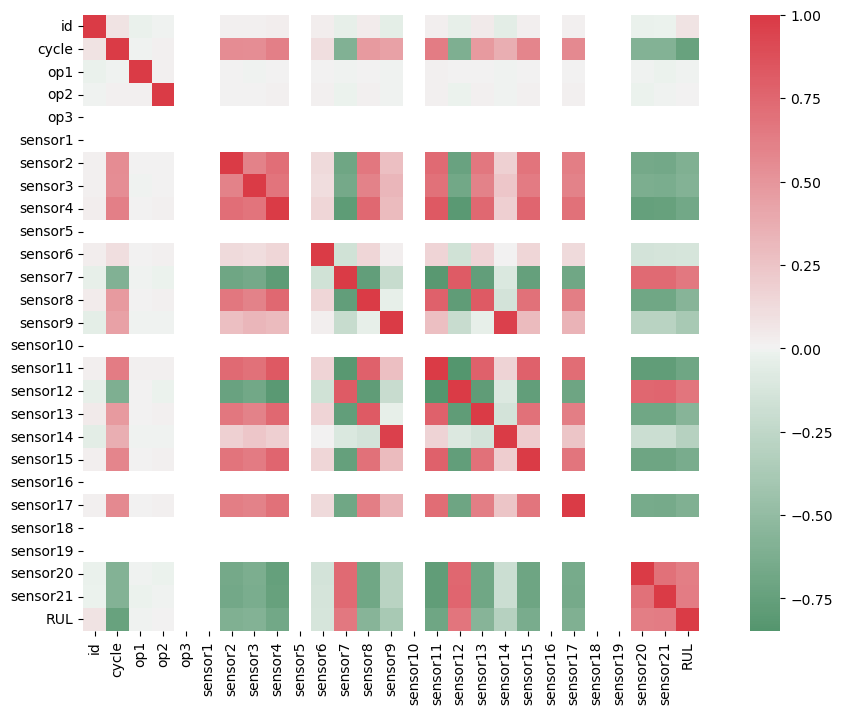

In [7]:
# RUL calculation function
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    # Merging the max_cycle dataframe with df based on 'id'
    result_frame = df.merge(max_cycle.to_frame(name="max_cycle"), left_on="id", right_index=True)
    # Calculating the RUL by subtracting 'cycle' from 'max_cycle'
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"]
    # Dropping the 'max_cycle' column
    result_frame.drop(["max_cycle"], axis=1, inplace=True)
    return result_frame

# Applying RUL calculation to jet_data
jet_data = RUL_calculator(jet_data, jet_id_and_rul)

# Creating a heatmap to visualize correlation in jet_data
plt.figure(figsize=(13, 8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap=cmap, center=0, annot=False, square=True)


<Axes: >

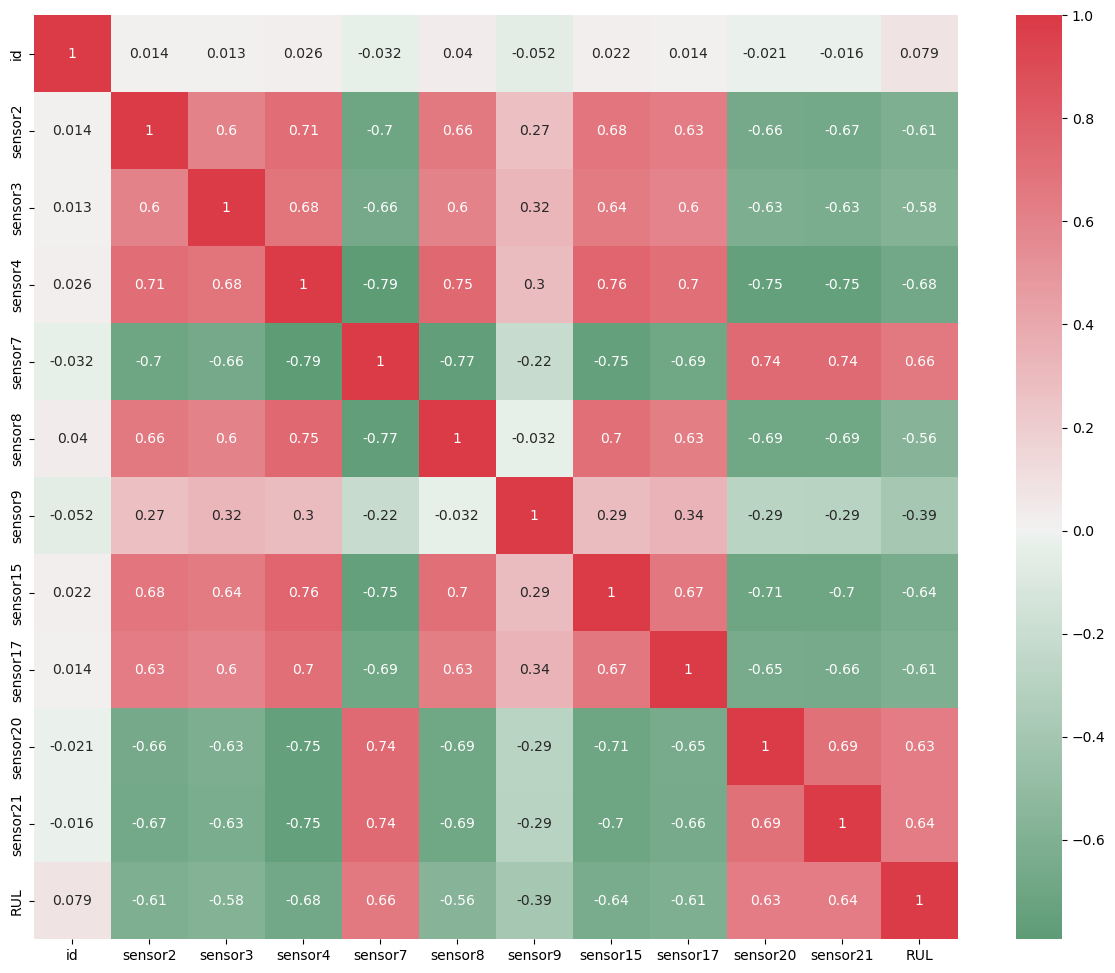

In [8]:

# Creating a new dataframe with relevant parameters by dropping unnecessary columns
jet_relevant_data = jet_data.drop(
    [
        "cycle",
        "op1",
        "op2",
        "op3",
        "sensor1",
        "sensor5",
        "sensor6",
        "sensor10",
        "sensor16",
        "sensor18",
        "sensor19",
        "sensor14",
        "sensor13",
        "sensor12",
        "sensor11",
    ],
    axis=1,
)

# Creating a heatmap to visualize correlation in jet_relevant_data
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap=cmap, center=0, annot=True, square=True)


In [9]:

# Scaling the relevant features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(["id", "RUL"], axis=1))
scaled_features = pd.DataFrame(
    scaled_features, columns=jet_relevant_data.drop(["id", "RUL"], axis=1).columns
)

# Adding back the 'id' and 'RUL' columns to the scaled_features dataframe
scaled_features["id"] = jet_relevant_data["id"]
scaled_features["RUL"] = jet_relevant_data["RUL"]

# Creating a new dataframe 'data' with scaled features
data = scaled_features.copy()

# Defining a threshold 'cycle' and creating a binary label column 'label' based on 'RUL'
cycle = 30
data["label"] = data["RUL"].apply(lambda x: 1 if x <= cycle else 0)


In [14]:
# Separating the features (X) and labels (y) for training and testing sets
y = data["label"]
X = data.drop(["RUL", "id", "label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Printing the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Initializing a RandomForestClassifier with a random state
classifier = RandomForestClassifier(random_state=90, oob_score=False, n_jobs=-1)

regressor = RandomForestRegressor(random_state=90, oob_score=False, n_jobs=-1)

# Defining the parameter grid for grid search
params = {
    "max_depth": [18, 20, 22],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [22, 25],
    "min_samples_leaf": [12, 10, 8],
    "n_estimators": [20, 30, 40],
}

# Initializing the Grid Search with accuracy metrics
grid_search = GridSearchCV(
    estimator=classifier, param_grid=params, cv=5, scoring="neg_mean_squared_error"
)



X_train shape: (16504, 10)
X_test shape: (4127, 10)
y_train shape: (16504,)
y_test shape: (4127,)


In [21]:
# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

# Getting the best model from the grid search
best_model = grid_search.best_estimator_

# Making predictions on the testing set using the best model
pred = best_model.predict(X_test)

Mean Squared Error: 0.043372910104191906
Root Mean Squared Error: 0.208261638580397
Mean Absolute Error: 0.043372910104191906
R^2 Score: 0.6575154544636905


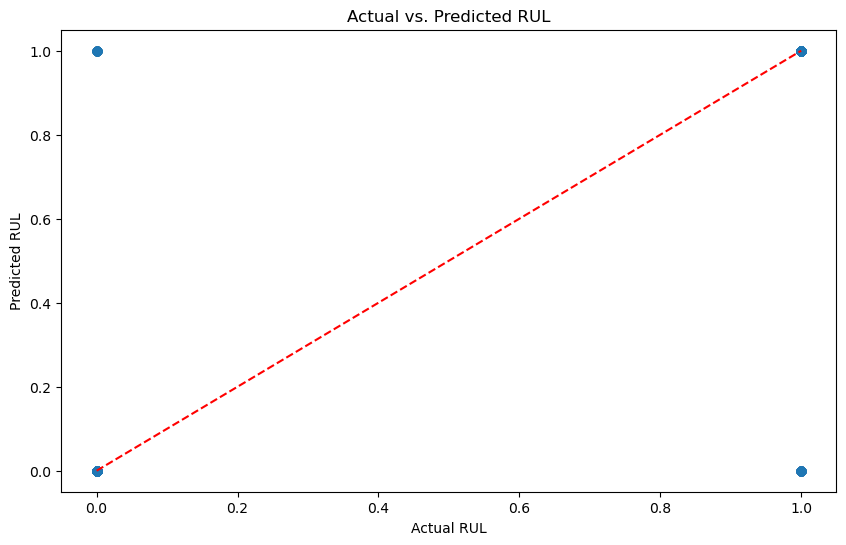

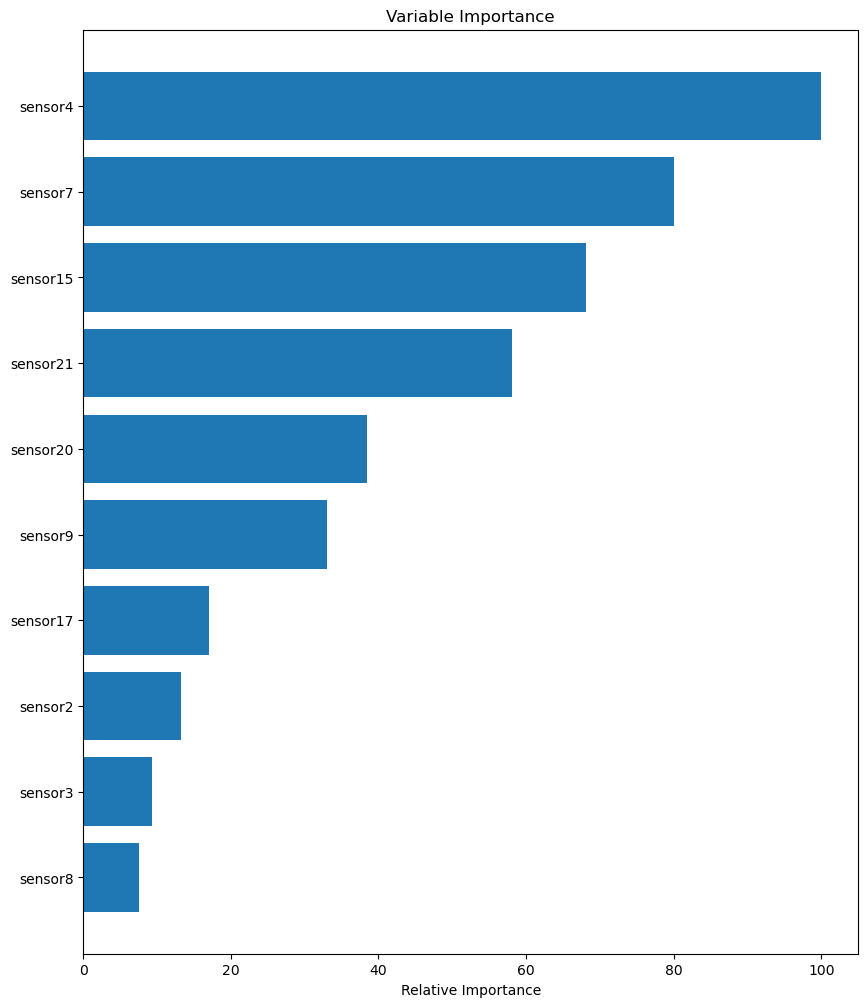

In [22]:
# Making predictions on the testing set using the best model
pred = grid_search.predict(X_test)

# Calculating and printing evaluation metrics
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.show()

# Plotting the relative importance of features based on the best model
feature_importance = best_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50 :]
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(10, 12))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()
